# Install Dependencies

### Install librosa

In [ ]:
conda install -c conda-forge librosa --y

### Install Numpy

In [ ]:
!pip install numpy

### Install Pandas

In [ ]:
!pip install pandas

### Install librosa

In [ ]:
!conda install -c conda-forge tensorflow --y

### Install scikit-learn

In [ ]:
!pip install -U scikit-learn

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



import warnings
warnings.filterwarnings("ignore")

## Read the data using librosa and pandas

In [ ]:
train = pd.read_csv("./Dataset/train.csv")

,new_id,genre
0,994050,0
1,994051,0
2,994077,0
3,994084,0
4,993076,0


In [2]:
SR =  5512 #11025 #22050
N_FFT =  64 #128 #512
HOP_LENGTH = N_FFT // 2
N_MELS = 64 
DURATION=10


def read_spectrogram(audio_data):
    """
        Return the sepctrogram for a given audio file.
    
    """
    
    spec = np.abs(librosa.stft(audio_data, hop_length = HOP_LENGTH  , n_fft = N_FFT  ))
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    return spec

def from_audio_to_MFCC(audio_data, n_mfcc=40 , metric = "mean"):
    """
        Return Mel-frequency cepstral coefficients (MFCC) for a given audio set of files.
        metric: 
            - mean: used to convert the resulting matrix (m*n) to a vector of means (1*m)
            - flatten: used to flatten the resulting matrix (m*n) to a vector of shape (1*(m*n))
            - None : return the original MFCC matrix
            
    """

    mfcc =  librosa.feature.mfcc(audio_data, n_mfcc)

    if metric == "flatten":                   
        mfcc = np.concatenate(mfcc)

    elif metric == "mean":
        mfcc = np.mean(mfcc, axis =1)

    elif metric == "None":
         return np.array(mfcc)
            
            
    return np.array(mfcc)


def plot_confusion_matrix(y_true, y_pred , title='Confusion matrix', cmap=plt.cm.gray_r):
    """
        plot a confusion matrix of true labels and predicted labels.
    """

    fig = plt.figure(figsize=(15,15))
    df_confusion = pd.DataFrame(confusion_matrix(y_true, y_pred))
    plt.matshow(df_confusion, cmap=cmap)
    
    plt.title(title)

    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

### Read the features and convert them to spectrograms and MFCCs

In [ ]:
X_spec=[]
X_mfcc = []
y=[]
ids=[]


train = pd.read_csv("./Dataset/train.csv")
directory = './Dataset/train'

i=1

# read an audio file using librosa
for id , label in zip(train["new_id"], train["genre"]):
    print("loading document #"+str(i)+" ...")
    i+=1
    
    try:
        file_path = './Dataset/train/00' + str(id) +".mp3"
        audio_data, _ = librosa.load(file_path, sr = SR , duration = DURATION )
        
    except:
        
        file_path = './Dataset/train/0' + str(id) +".mp3"
        audio_data, _ = librosa.load(file_path, sr = SR , duration = DURATION )
    
    ids.append(id)
    
    #convert the audio file to a spectrogram and append the result to X_spec
    X_spec.append(read_spectrogram(audio_data))
    
    #convert the audio file to a MFCC and append the result to X_mfcc
    X_mfcc.append(from_audio_to_MFCC(audio_data , metric = "mean"))
    
    y.append(label)
    
X_spec = np.array(X_spec)
X_mfcc = np.array(X_mfcc)
y = np.array(y)

### Save the results as .npz

In [23]:
%time np.savez_compressed('./Dataset/compressed_spec_mfcc', a = X_spec, b= X_mfcc , c = y)

CPU times: user 17.3 s, sys: 527 ms, total: 17.8 s
Wall time: 17.9 s


## Load Spectrograms , MFCCs, and y

In [7]:
X_spec = np.load('./Dataset/compressed_spec_mfcc' , allow_pickle=True)["a"]

In [ ]:
X_mfcc = np.load('./Dataset/compressed_spec_mfcc' , allow_pickle=True)["b"]

In [8]:
y = np.load('./Dataset/compressed_spec_mfcc' , allow_pickle=True)["c"]

In [9]:
X_spec.shape , X_mfcc.shape , y. shape

(2400, 1025, 1292)

## build a sequential Neural Network with spectrograms

In [10]:
X_spec.shape

(2400, 1025, 1292)

In [11]:
#(33, 862)
in_shape = list(X_spec[0].shape)
out_shape = len(set(y))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape= in_shape ),#[33, 862]), 
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(200, activation="relu"),
    #keras.layers.Dense(2, activation="relu"),
    keras.layers.Dense(out_shape, activation="softmax")
])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.sparse_categorical_accuracy]
             )

2022-05-09 19:21:06.668403: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1324300)           0         
_________________________________________________________________
dense (Dense)                (None, 50)                66215050  
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1

In [13]:
history = model.fit(X_spec, y, epochs=3, validation_split=0.2)

2022-05-09 19:21:15.834507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/3
45/45 [==============================] - 24s 494ms/step - loss: 2646.4727 - sparse_categorical_accuracy: 0.2283 - val_loss: 2.0059 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/3
45/45 [==============================] - 23s 503ms/step - loss: 1.6492 - sparse_categorical_accuracy: 0.2560 - val_loss: 2.3342 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/3
45/45 [==============================] - 20s 449ms/step - loss: 1.5512 - sparse_categorical_accuracy: 0.2614 - val_loss: 2.7182 - val_sparse_categorical_accuracy: 0.0000e+00


In [310]:
model.evaluate(X_spec, y)

75/75 [==============================] - 20s 234ms/step - loss: 2.9971 - sparse_categorical_accuracy: 0.1667


[2.9971306324005127, 0.1666666716337204]

<Figure size 1080x1080 with 0 Axes>

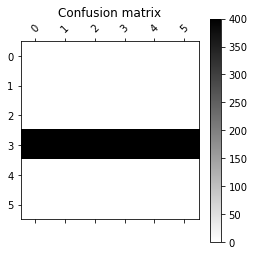

In [14]:
pred = np.argmax(model.predict(X_spec) , axis =1 )
plot_confusion_matrix(pred, y)

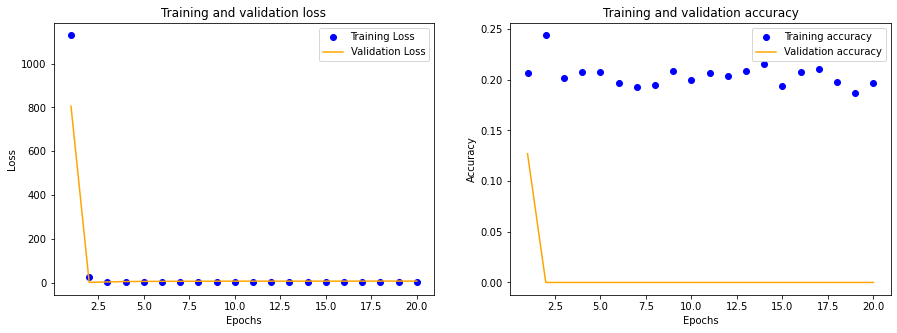

In [153]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

# KNN classifier

### Flatten MFCC features 

In [236]:
flattened = []
for x in X_mfcc:
    flattened.append(np.concatenate(x))
flattened = np.array(flattened)

In [269]:
flattened.shape

(2400, 25840)

### Standardization

In [270]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
flattened_stand = sc.fit_transform(flattened)

### Dimensionality Reduction using PCA

In [271]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2000)

%time X_pca_reduced = pca.fit_transform(flattened_stand)


CPU times: user 1min 39s, sys: 18 s, total: 1min 57s
Wall time: 20.4 s


In [272]:
X_pca_reduced.shape , flattened_stand.shape

((2400, 2000), (2400, 25840))

### classifying using KNN

In [275]:
model = KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)

### 5-Fold accuracy

In [276]:
scores = cross_val_score(model, X_pca_reduced, y, cv=5)

m = np.array(scores).mean()
print(m)

0.3120833333333333


### plot confusion matrix for KNN

<Figure size 1080x1080 with 0 Axes>

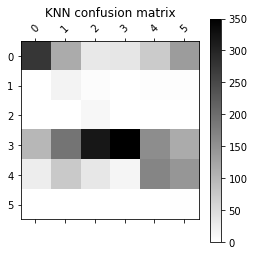

In [282]:
plot_confusion_matrix( model.fit(X_pca_reduced , y).predict(X_pca_reduced) , y , title="KNN confusion matrix")

# SVM Classifier

In [327]:
model = SVC(kernel='poly',degree = 1, C= 0.1, random_state=42)

### 5-Fold accuracy

In [ ]:
scores = cross_val_score(model, X_pca_reduced, y, cv=5)

print(np.array(scores).mean())

In [326]:
flattened.shape

(2400, 25840)

### plot confusion matrix for SVM

In [325]:
plot_confusion_matrix( model.fit(X_pca_reduced , y).predict(X_pca_reduced) , y , title="SVM confusion matrix")

ValueError: in user code:

    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/ajararweh/opt/anaconda3/envs/audio_class/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_162 is incompatible with the layer: expected axis -1 of input shape to have value 1324300 but received input with shape (32, 25840)
